In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


# 1.Data Loading

In [8]:
import pandas as pd
train=pd.read_parquet(r"/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet")
train_series=train.head(100000)

In [9]:
test_series = pd.read_parquet(r"/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet")

In [10]:
test_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [11]:
train_events=pd.read_csv(r"/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [12]:
sample_submission=pd.read_csv(r"/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv")
sample_submission.head()

,row_id,series_id,step,event,score
0,0,038441c925bb,100,onset,0.0
1,1,038441c925bb,105,wakeup,0.0
2,2,03d92c9f6f8a,80,onset,0.5
3,3,03d92c9f6f8a,110,wakeup,0.5
4,4,0402a003dae9,90,onset,1.0


# 2.Data Cleaning¶

## Data Type Conversion

In [13]:
train_series.dtypes

series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
dtype: object

In [14]:
test_series.dtypes

series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
dtype: object

In [15]:
train_events.dtypes

series_id     object
night          int64
event         object
step         float64
timestamp     object
dtype: object

In [16]:
sample_submission.dtypes

row_id         int64
series_id     object
step           int64
event         object
score        float64
dtype: object

In [17]:
# Convert timestamp to datetime with UTC
train_series.loc[:, 'timestamp'] = pd.to_datetime(train_series['timestamp'], utc=True)
test_series.loc[:, 'timestamp'] = pd.to_datetime(test_series['timestamp'], utc=True)
train_events.loc[:, 'timestamp'] = pd.to_datetime(train_events['timestamp'], utc=True)

# Ensure categorical columns are strings
train_series.loc[:, 'series_id'] = train_series['series_id'].astype(str)
test_series.loc[:, 'series_id'] = test_series['series_id'].astype(str)
train_events.loc[:, 'series_id'] = train_events['series_id'].astype(str)
train_events.loc[:, 'event'] = train_events['event'].astype(str)


In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Convert timestamp to datetime
train_series['timestamp'] = pd.to_datetime(train_series['timestamp'],utc=True)
test_series['timestamp'] = pd.to_datetime(test_series['timestamp'])
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'],utc=True)

# Ensure categorical columns are strings
train_series['series_id'] = train_series['series_id'].astype(str)
test_series['series_id'] = test_series['series_id'].astype(str)
train_events['series_id'] = train_events['series_id'].astype(str)
train_events['event'] = train_events['event'].astype(str)

## Handle Missing Values

In [20]:
train_series.isnull().sum()

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64

In [21]:
train_events.isnull().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

In [22]:
test_series.isnull().sum()

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64

In [23]:
sample_submission.isnull().sum()

row_id       0
series_id    0
step         0
event        0
score        0
dtype: int64

In [24]:
train_events['step'].fillna(method='ffill', inplace=True)
train_events['timestamp'].fillna(method='ffill', inplace=True)

In [25]:
train_events.isnull().sum()

series_id    0
night        0
event        0
step         0
timestamp    0
dtype: int64

## Check for Duplicates

In [26]:
print("Duplicates in Train Series:", train_series.duplicated().sum())

Duplicates in Train Series: 0


In [27]:
print("\nDuplicates in Train Events:", train_events.duplicated().sum())


Duplicates in Train Events: 0


In [28]:
print("\nDuplicates in Test Series:", test_series.duplicated().sum())


Duplicates in Test Series: 0


In [29]:
print("\nDuplicates in sample data:",sample_submission.duplicated().sum())


Duplicates in sample data: 0


## Outlier detection

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

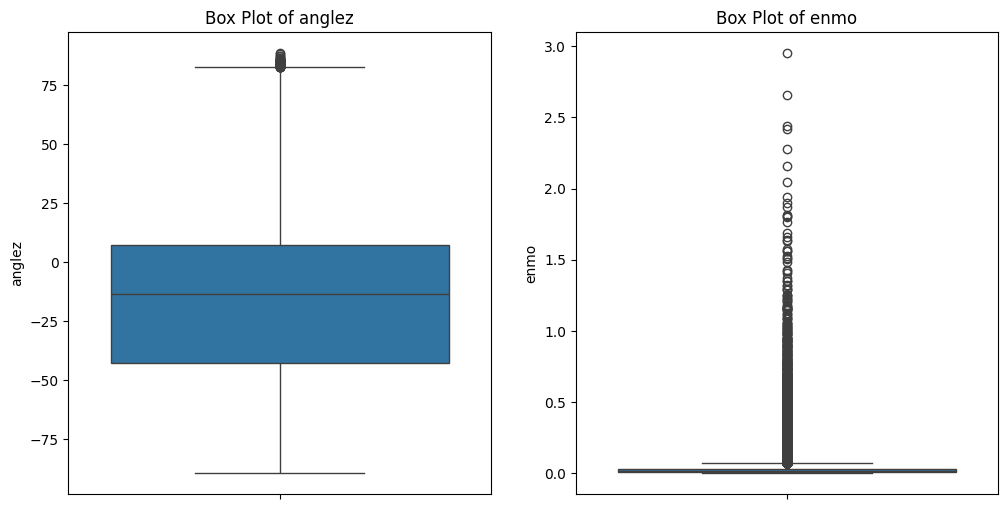

In [31]:
# Box plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=train_series['anglez'])
plt.title('Box Plot of anglez')
plt.subplot(1, 2, 2)
sns.boxplot(y=train_series['enmo'])
plt.title('Box Plot of enmo')
plt.show()

In [32]:
# IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

anglez_outliers = detect_outliers_iqr(train_series, 'anglez')
enmo_outliers = detect_outliers_iqr(train_series, 'enmo')
print(f"Anglez Outliers: {len(anglez_outliers)}")
print(f"ENMO Outliers: {len(enmo_outliers)}")

Anglez Outliers: 218
ENMO Outliers: 9090


In [33]:
# Log transformation for enmo
train_series['enmo'] = np.log1p(train_series['enmo'])
test_series['enmo'] = np.log1p(test_series['enmo'])

# Capping anglez
anglez_lower, anglez_upper = train_series['anglez'].quantile([0.01, 0.99])
train_series['anglez'] = train_series['anglez'].clip(lower=anglez_lower, upper=anglez_upper)
test_series['anglez'] = test_series['anglez'].clip(lower=anglez_lower, upper=anglez_upper)

# 3.Predictive Model Building (Supervised Machine Learning)

## Selecting Output and Input Variables

+ Target Variable: event (categorical: onset or wakeup) from train_events.
+ Task: Classification (binary classification for each event type).
+ Input Features: Derived from train_series (anglez, enmo, and engineered features).

## Feature Engineering

In [34]:
# Merge train_series with train_events
train_events['step'] = train_events['step'].astype(int)
merged_data = train_series.merge(train_events[['series_id', 'step', 'event']], on=['series_id', 'step'], how='left')

In [35]:
# Create target variable: 1 for onset, 2 for wakeup, 0 for non-event
merged_data['target'] = 0
merged_data.loc[merged_data['event'] == 'onset', 'target'] = 1
merged_data.loc[merged_data['event'] == 'wakeup', 'target'] = 2

In [36]:
# Feature engineering
def create_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    
    # Rolling statistics for anglez and enmo
    for window in [12, 60]:  # 1 hour and 5 hours (assuming 5-min steps)
        df[f'anglez_mean_{window}'] = df.groupby('series_id')['anglez'].rolling(window, center=True).mean().reset_index(level=0, drop=True)
        df[f'anglez_std_{window}'] = df.groupby('series_id')['anglez'].rolling(window, center=True).std().reset_index(level=0, drop=True)
        df[f'enmo_mean_{window}'] = df.groupby('series_id')['enmo'].rolling(window, center=True).mean().reset_index(level=0, drop=True)
        df[f'enmo_std_{window}'] = df.groupby('series_id')['enmo'].rolling(window, center=True).std().reset_index(level=0, drop=True)
    
    # Fill NaN from rolling stats
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df

In [37]:
merged_data = create_features(merged_data)

In [38]:
merged_data

,series_id,step,timestamp,anglez,enmo,event,target,hour,dayofweek,anglez_mean_12,anglez_std_12,enmo_mean_12,enmo_std_12,anglez_mean_60,anglez_std_60,enmo_mean_60,enmo_std_60
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.021468,onset,0,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.021272,onset,0,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.021370,onset,0,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.021076,onset,0,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.021272,onset,0,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99997,038441c925bb,99995,2018-08-20 14:22:55+00:00,47.771099,0.005684,wakeup,0,14,0,43.841525,5.095339,0.003590,0.005063,47.002893,5.602375,0.002719,0.003906
99998,038441c925bb,99996,2018-08-20 14:23:00+00:00,48.725399,0.000300,wakeup,0,14,0,43.841525,5.095339,0.003590,0.005063,47.002893,5.602375,0.002719,0.003906
99999,038441c925bb,99997,2018-08-20 14:23:05+00:00,48.909401,0.000000,wakeup,0,14,0,43.841525,5.095339,0.003590,0.005063,47.002893,5.602375,0.002719,0.003906
100000,038441c925bb,99998,2018-08-20 14:23:10+00:00,48.777802,0.000100,wakeup,0,14,0,43.841525,5.095339,0.003590,0.005063,47.002893,5.602375,0.002719,0.003906


In [39]:
test_series = create_features(test_series)
test_series

,series_id,step,timestamp,anglez,enmo,hour,dayofweek,anglez_mean_12,anglez_std_12,enmo_mean_12,enmo_std_12,anglez_mean_60,anglez_std_60,enmo_mean_60,enmo_std_60
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.021468,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.021272,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.021370,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.021076,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.021272,19,1,2.689800,0.143648,0.021541,0.000417,-35.181107,50.634105,0.017159,0.008267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0402a003dae9,145,2018-12-18 17:57:05+00:00,-59.696899,0.058363,17,1,-24.543934,17.384186,0.045684,0.020767,-39.983990,23.123349,0.056530,0.068637
446,0402a003dae9,146,2018-12-18 17:57:10+00:00,-35.656601,0.041814,17,1,-24.543934,17.384186,0.045684,0.020767,-39.983990,23.123349,0.056530,0.068637
447,0402a003dae9,147,2018-12-18 17:57:15+00:00,-21.582399,0.030432,17,1,-24.543934,17.384186,0.045684,0.020767,-39.983990,23.123349,0.056530,0.068637
448,0402a003dae9,148,2018-12-18 17:57:20+00:00,-42.616001,0.032274,17,1,-24.543934,17.384186,0.045684,0.020767,-39.983990,23.123349,0.056530,0.068637


# Exploratory Data Analysis

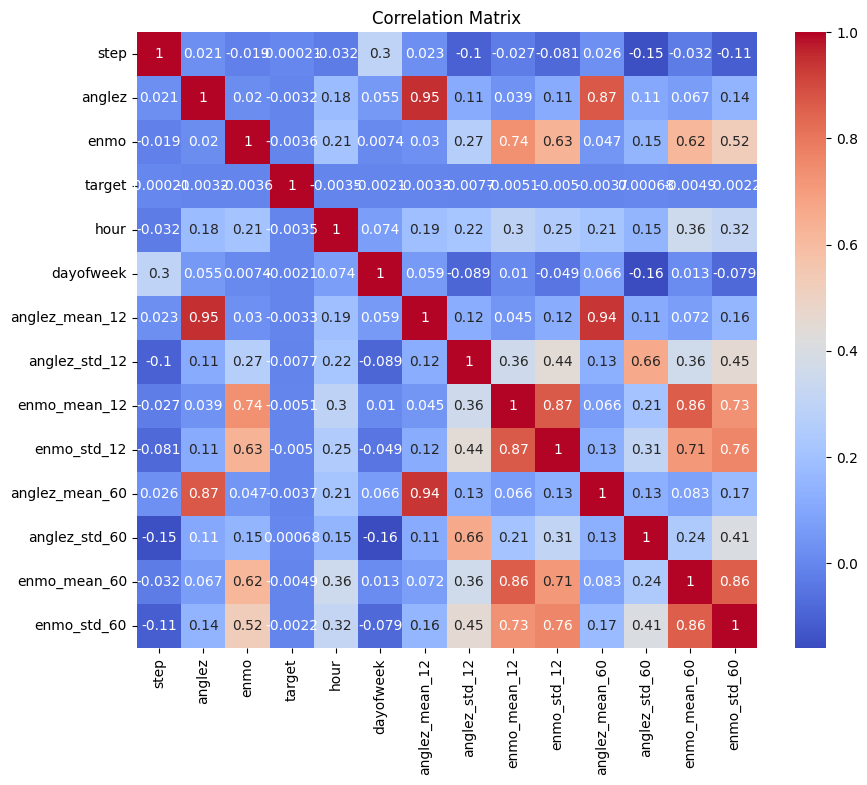

In [40]:
# Select only numeric columns
numeric_data = merged_data.select_dtypes(include=['number'])

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


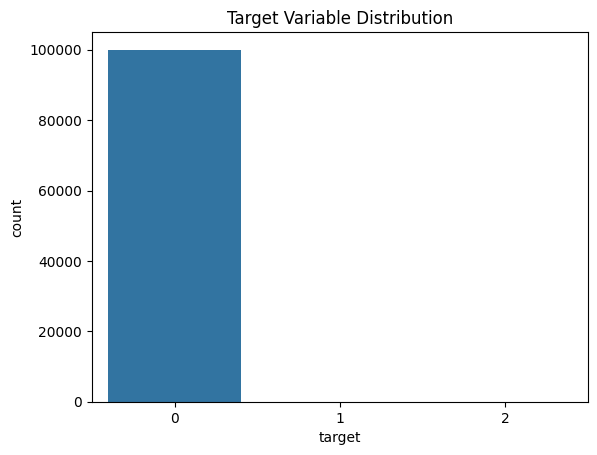

In [41]:
# Distribution of target variable
sns.countplot(x='target', data=merged_data)
plt.title('Target Variable Distribution')
plt.show()

In [42]:
# Pair plot for key features
#sns.pairplot(merged_data[['anglez', 'enmo', 'target']], hue='target')
#plt.show()

# Feature Selection

In [50]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [121]:
selector = SelectKBest(score_func=mutual_info_classif, k=8)
X_selected = selector.fit_transform(X, y)
selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Selected Features:", selected_features)

# Now refit the scaler on X_selected (the 8-feature data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Optionally fit PCA here (if you're using it)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)


Selected Features: ['enmo', 'hour', 'dayofweek', 'anglez_std_12', 'enmo_std_12', 'anglez_mean_60', 'anglez_std_60', 'enmo_mean_60']


## Handle Multicollinearity

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [55]:
# Calculating VIF
X_vif = merged_data[selected_features]
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

          Feature       VIF
0          anglez  4.910538
1            hour  3.596233
2       dayofweek  2.750318
3   anglez_std_12  3.358095
4     enmo_std_12  2.831152
5  anglez_mean_60  5.119907
6   anglez_std_60  3.639104
7    enmo_mean_60  4.160790


**Handling Multicollinearity:**
+ If VIF > 5 for some features (e.g., anglez_mean_12 and anglez_mean_60), drop one of the correlated features or use PCA.
+ Justification: PCA reduces dimensionality while retaining variance, mitigating multicollinearity.


In [56]:
from sklearn.decomposition import PCA

In [57]:
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_selected)
print("PCA Components:", pca.n_components_)

PCA Components: 3


## Handle Class Imbalance¶

**The target variable is imbalanced (many 0 vs. few 1 and 2). Use SMOTE for oversampling:**

In [60]:
from imblearn.over_sampling import SMOTE


In [61]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_pca, y)

# 4.Data Preprocessing¶

## Train-Test Split

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

## Scaling Numerical Features¶

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


+ Justification: StandardScaler is chosen because it standardizes features to have zero mean and unit variance, which is suitable for algorithms like SVM and KNN that are sensitive to feature scales.

# 5.Model Building

**Since the task is classification, we will use the following algorithms:**

+ K-Nearest Neighbors (KNN)
+ Naïve Bayes
+ Decision Tree
+ Logistic Regression
+ Support Vector Classifier (SVC)
+ Random Forest
+ XGBoost

### Algorithm Assumptions¶

+ KNN: Assumes data points with similar features have similar labels. Requires scaled features.
+ Naïve Bayes: Assumes feature independence. Suitable for probabilistic classification.
+ Decision Tree: No assumptions about data distribution but prone to overfitting.
+ Logistic Regression: Assumes linear decision boundaries and no multicollinearity.
+ SVC: Assumes data is separable in a high-dimensional space. Sensitive to scaling.
+ Random Forest: Robust to noise and overfitting, handles non-linear relationships.
+ XGBoost: Handles imbalanced data well, robust to outliers.

## Model Building

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

In [79]:
models = {'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=27),
    'Logistic Regression': LogisticRegression(max_iter=100, random_state=27),
    'Random Forest': RandomForestClassifier(random_state=27),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

In [80]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    

In [81]:
results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test_scaled), multi_class='ovr')}

In [82]:
print(f"\n{name} Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


XGBoost Confusion Matrix:
[[19530   270   198]
 [    0 19991     7]
 [    0     1 19997]]


In [83]:
results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df)


Model Performance:
         Accuracy  F1 Score   ROC AUC
XGBoost  0.992066  0.992044  0.999182


**Metric Selection:**
+ F1 Score is the best metric due to class imbalance (non-events vs. onset/wakeup). It balances precision and recall, critical for detecting rare events.
+ Justification: Accuracy can be misleading with imbalanced data, and ROC AUC is less interpretable for multi-class problems.

# 6.Model Validation and Hyperparameter Tuning

## Cross-Validation¶

In [71]:
from sklearn.model_selection import cross_val_score

In [84]:
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    print(f"{name} CV F1 Score: {scores.mean():.4f} ± {scores.std():.4f}")

KNN CV F1 Score: 0.9945 ± 0.0004
Naive Bayes CV F1 Score: 0.6410 ± 0.0016
Decision Tree CV F1 Score: 0.9964 ± 0.0003
Logistic Regression CV F1 Score: 0.4807 ± 0.0014
Random Forest CV F1 Score: 0.9976 ± 0.0003
XGBoost CV F1 Score: 0.9921 ± 0.0006


## Hyperparameter Tuning with Optuna

In [74]:
pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.6/580.6 kB 28.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [75]:
import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float(' subs', 0.5, 1.0)
    }
    model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train_scaled, y_train)
    return f1_score(y_test, model.predict(X_test_scaled), average='weighted')


In [92]:
import warnings
warnings.filterwarnings('ignore')

In [97]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best Parameters:", study.best_params)

[I 2025-05-01 16:13:01,146] A new study created in memory with name: no-name-d11a40e8-5f87-465b-92a2-f0aa33537313
[I 2025-05-01 16:13:04,972] Trial 0 finished with value: 0.9603043898016097 and parameters: {'max_depth': 3, 'learning_rate': 0.09248110283191609, 'n_estimators': 341, ' subs': 0.908562162000568}. Best is trial 0 with value: 0.9603043898016097.
[I 2025-05-01 16:13:16,827] Trial 1 finished with value: 0.9966126436917614 and parameters: {'max_depth': 9, 'learning_rate': 0.25787427041867095, 'n_estimators': 278, ' subs': 0.7620332940238481}. Best is trial 1 with value: 0.9966126436917614.
[I 2025-05-01 16:13:26,109] Trial 2 finished with value: 0.9967128856532694 and parameters: {'max_depth': 8, 'learning_rate': 0.2501988917969534, 'n_estimators': 390, ' subs': 0.8601123595673292}. Best is trial 2 with value: 0.9967128856532694.
[I 2025-05-01 16:13:33,508] Trial 3 finished with value: 0.9656737187049623 and parameters: {'max_depth': 4, 'learning_rate': 0.04005377860457273, 'n_

Best Parameters: {'max_depth': 9, 'learning_rate': 0.21717638549770835, 'n_estimators': 274, ' subs': 0.8516726585050884}


In [100]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)  # ✅ Correct name
    }
    
    model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train_scaled, y_train)
    
    preds = model.predict(X_test_scaled)
    return f1_score(y_test, preds, average='weighted')


In [102]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best Parameters:", study.best_params)



[I 2025-05-01 16:19:14,377] A new study created in memory with name: no-name-345b3d98-a1ac-4849-9b3f-635d873a0f84
[I 2025-05-01 16:19:19,394] Trial 0 finished with value: 0.9533859160835909 and parameters: {'max_depth': 3, 'learning_rate': 0.09589346168039567, 'n_estimators': 301, 'subsample': 0.8703980819951155}. Best is trial 0 with value: 0.9533859160835909.
[I 2025-05-01 16:19:23,396] Trial 1 finished with value: 0.9953923727890596 and parameters: {'max_depth': 7, 'learning_rate': 0.19080529635327917, 'n_estimators': 195, 'subsample': 0.7201623398620823}. Best is trial 1 with value: 0.9953923727890596.
[I 2025-05-01 16:19:29,026] Trial 2 finished with value: 0.9778657497602193 and parameters: {'max_depth': 6, 'learning_rate': 0.06733195489032845, 'n_estimators': 191, 'subsample': 0.717434902988445}. Best is trial 1 with value: 0.9953923727890596.
[I 2025-05-01 16:19:37,634] Trial 3 finished with value: 0.9958772754533676 and parameters: {'max_depth': 8, 'learning_rate': 0.113751425

Best Parameters: {'max_depth': 10, 'learning_rate': 0.2238353617502979, 'n_estimators': 444, 'subsample': 0.8446588424827046}


In [103]:

# Training final model with best parameters
best_model = XGBClassifier(**study.best_params, random_state=27, use_label_encoder=False, eval_metric='mlogloss')
best_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2238353617502979,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=444, n_jobs=None,
              num_parallel_tree=None, ...)

## Regularization

In [104]:
log_reg_ridge = LogisticRegression(penalty='l2', C=0.1, max_iter=100, random_state=27)
log_reg_ridge.fit(X_train_scaled, y_train)
print("Ridge Logistic Regression F1 Score:", f1_score(y_test, log_reg_ridge.predict(X_test_scaled), average='weighted'))

Ridge Logistic Regression F1 Score: 0.47622349224460897


# 7.Prediction on Test Set

In [117]:
# Applying preprocessing to test set
X_test_final = test_series[selected_features]
X_test_final_scaled = scaler.transform(X_test_final)
X_test_final_pca = pca.transform(X_test_final_scaled)

In [118]:
# Predict
test_predictions = best_model.predict(X_test_final_pca)
test_series['event'] = test_predictions
test_series['event'] = test_series['event'].map({0: 'none', 1: 'onset', 2: 'wakeup'})


In [119]:
# Filter onset and wakeup events
submission = test_series[test_series['event'].isin(['onset', 'wakeup'])][['series_id', 'step', 'event']]
submission['score'] = best_model.predict_proba(X_test_final_pca)[test_series['event'].isin(['onset', 'wakeup'])][:, 1:].max(axis=1)
submission['row_id'] = range(len(submission))


In [120]:

# Reorder columns
submission = submission[['row_id', 'series_id', 'step', 'event', 'score']]
submission.to_csv('submission.csv', index=False)

In [123]:

train_series.to_csv('train_series_processed.csv', index=False)


In [124]:

train_events.to_csv('train_events_processed.csv', index=False)


In [125]:

test_series.to_csv('test_series_processed.csv', index=False)

In [126]:

sample_submission.to_csv('sample_submission_processed.csv', index=False)

In [130]:
import os
print(os.getcwd())


/kaggle/working
